In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  


In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [0.9, 1, 0.95])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [0.9  0.9  1.   ... 1.   0.95 0.95] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.35369	test-merror:0.53451
[1]	train-merror:0.27459	test-merror:0.48475
[2]	train-merror:0.22920	test-merror:0.45265
[3]	train-merror:0.20398	test-merror:0.43018
[4]	train-merror:0.18255	test-merror:0.43018
[5]	train-merror:0.16129	test-merror:0.40128
[6]	train-merror:0.15217	test-merror:0.41252
[7]	train-merror:0.14298	test-merror:0.39807
[8]	train-merror:0.13753	test-merror:0.39647
[9]	train-merror:0.13270	test-merror:0.39486
[10]	train-merror:0.12623	test-merror:0.39968
[11]	train-merror:0.12542	test-merror:0.39165
[12]	train-merror:0.12068	test-merror:0.38684
[13]	train-merror:0.11425	test-merror:0.37560
[14]	train-merror:0.11133	test-merror:0.39005
[15]	train-merror:0.10659	test-merror:0.39326
[16]	train-merror:0.10744	test-merror:0.38363
[17]	train-merror:0.10867	test-merror:0.38042
[18]	train-merror:0.10742	test-merror:0.39165
[19]	train-merror:0.10824	test-merror:0.37560
[20]	train-merror:0.10285	test-merror:0.37881
[21]	train-merror:0.10245	test-merror:0.3756

[177]	train-merror:0.03277	test-merror:0.34671
[178]	train-merror:0.03199	test-merror:0.34671
[179]	train-merror:0.03279	test-merror:0.34992
[180]	train-merror:0.03235	test-merror:0.34831
[181]	train-merror:0.03199	test-merror:0.34992
[182]	train-merror:0.03237	test-merror:0.34992
[183]	train-merror:0.03199	test-merror:0.34992
[184]	train-merror:0.03157	test-merror:0.34992
[185]	train-merror:0.03197	test-merror:0.35152
[186]	train-merror:0.03123	test-merror:0.35152
[187]	train-merror:0.03161	test-merror:0.34992
[188]	train-merror:0.03161	test-merror:0.34992
[189]	train-merror:0.03043	test-merror:0.34831
[190]	train-merror:0.03040	test-merror:0.34671
[191]	train-merror:0.03000	test-merror:0.34992
[192]	train-merror:0.03000	test-merror:0.34831
[193]	train-merror:0.02960	test-merror:0.34831
[194]	train-merror:0.03043	test-merror:0.35152
[195]	train-merror:0.03123	test-merror:0.34992
[196]	train-merror:0.03083	test-merror:0.34992
[197]	train-merror:0.03000	test-merror:0.35313
[198]	train-m

[352]	train-merror:0.00965	test-merror:0.33708
[353]	train-merror:0.00965	test-merror:0.33868
[354]	train-merror:0.00965	test-merror:0.33868
[355]	train-merror:0.01005	test-merror:0.33708
[356]	train-merror:0.00927	test-merror:0.33708
[357]	train-merror:0.00969	test-merror:0.33708
[358]	train-merror:0.00969	test-merror:0.33708
[359]	train-merror:0.00927	test-merror:0.33708
[360]	train-merror:0.00927	test-merror:0.33708
[361]	train-merror:0.00927	test-merror:0.33547
[362]	train-merror:0.00927	test-merror:0.33708
[363]	train-merror:0.00927	test-merror:0.33868
[364]	train-merror:0.00886	test-merror:0.33708
[365]	train-merror:0.00886	test-merror:0.33708
[366]	train-merror:0.00846	test-merror:0.34029
[367]	train-merror:0.00886	test-merror:0.34029
[368]	train-merror:0.00886	test-merror:0.33868
[369]	train-merror:0.00886	test-merror:0.34029
[370]	train-merror:0.00886	test-merror:0.33868
[371]	train-merror:0.00848	test-merror:0.34189
[372]	train-merror:0.00848	test-merror:0.34350
[373]	train-m

[527]	train-merror:0.00360	test-merror:0.34029
[528]	train-merror:0.00360	test-merror:0.34189
[529]	train-merror:0.00360	test-merror:0.34189
[530]	train-merror:0.00360	test-merror:0.34189
[531]	train-merror:0.00360	test-merror:0.34029
[532]	train-merror:0.00360	test-merror:0.34029
[533]	train-merror:0.00317	test-merror:0.33868
[534]	train-merror:0.00317	test-merror:0.34029
[535]	train-merror:0.00317	test-merror:0.34029
[536]	train-merror:0.00360	test-merror:0.34189
[537]	train-merror:0.00360	test-merror:0.34029
[538]	train-merror:0.00360	test-merror:0.34029
[539]	train-merror:0.00360	test-merror:0.34029
[540]	train-merror:0.00360	test-merror:0.34029
[541]	train-merror:0.00360	test-merror:0.34029
[542]	train-merror:0.00317	test-merror:0.33708
[543]	train-merror:0.00317	test-merror:0.33708
[544]	train-merror:0.00317	test-merror:0.33708
[545]	train-merror:0.00317	test-merror:0.33868
[546]	train-merror:0.00317	test-merror:0.33708
[547]	train-merror:0.00317	test-merror:0.33708
[548]	train-m

[702]	train-merror:0.00119	test-merror:0.33226
[703]	train-merror:0.00119	test-merror:0.33226
[704]	train-merror:0.00119	test-merror:0.33387
[705]	train-merror:0.00119	test-merror:0.33226
[706]	train-merror:0.00119	test-merror:0.33387
[707]	train-merror:0.00119	test-merror:0.33387
[708]	train-merror:0.00119	test-merror:0.33387
[709]	train-merror:0.00119	test-merror:0.33387
[710]	train-merror:0.00119	test-merror:0.33387
[711]	train-merror:0.00119	test-merror:0.33387
[712]	train-merror:0.00119	test-merror:0.33387
[713]	train-merror:0.00119	test-merror:0.33226
[714]	train-merror:0.00119	test-merror:0.33066
[715]	train-merror:0.00119	test-merror:0.33066
[716]	train-merror:0.00119	test-merror:0.33066
[717]	train-merror:0.00119	test-merror:0.32905
[718]	train-merror:0.00119	test-merror:0.33066
[719]	train-merror:0.00119	test-merror:0.33066
[720]	train-merror:0.00119	test-merror:0.33066
[721]	train-merror:0.00119	test-merror:0.33226
[722]	train-merror:0.00119	test-merror:0.33066
[723]	train-m

[877]	train-merror:0.00038	test-merror:0.32424
[878]	train-merror:0.00038	test-merror:0.32424
[879]	train-merror:0.00038	test-merror:0.32424
[880]	train-merror:0.00038	test-merror:0.32424
[881]	train-merror:0.00038	test-merror:0.32424
[882]	train-merror:0.00038	test-merror:0.32424
[883]	train-merror:0.00038	test-merror:0.32424
[884]	train-merror:0.00038	test-merror:0.32424
[885]	train-merror:0.00038	test-merror:0.32263
[886]	train-merror:0.00038	test-merror:0.32424
[887]	train-merror:0.00038	test-merror:0.32424
[888]	train-merror:0.00038	test-merror:0.32424
[889]	train-merror:0.00038	test-merror:0.32424
[890]	train-merror:0.00038	test-merror:0.32424
[891]	train-merror:0.00038	test-merror:0.32424
[892]	train-merror:0.00038	test-merror:0.32424
[893]	train-merror:0.00038	test-merror:0.32424
[894]	train-merror:0.00038	test-merror:0.32424
[895]	train-merror:0.00038	test-merror:0.32424
[896]	train-merror:0.00038	test-merror:0.32424
[897]	train-merror:0.00038	test-merror:0.32424
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6757624398073836 

Train Score
 0.9995987158908507 

CONFUSSION MATRIX
 [[174  35  11]
 [ 39 117  44]
 [ 24  49 130]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.73      0.79      0.76       220
      netral       0.58      0.58      0.58       200
     positif       0.70      0.64      0.67       203

    accuracy                           0.68       623
   macro avg       0.67      0.67      0.67       623
weighted avg       0.68      0.68      0.67       623
 



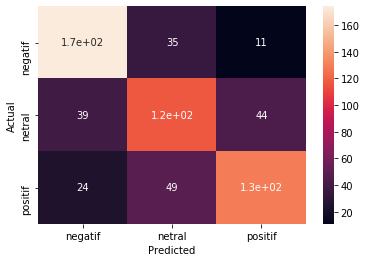

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])